# CONTENTS

1. River Dataset Exploration </br>
      a. looks at the rows of the river gdf and plots them </br>
</br>
2. Inspect KC Data </br>
      a. understand how the river data can be combined with KC data </br>
</br>
3. Combine River and KC Data into Chips </br>
      a. plot chips on top of RiverDataset with increased granularity than at an object level </br>
      b. plot an example chip with both river and KC objects </br>
</br>
4. Implement Chip Logic in rd.py </br>
      a. test if the new chip generation logic is implemented correctly in rd.py (testing in rd_copy_copy.py) </br>

# Load + Explore the River Dataset

In [14]:
import torch
from torchgeo.datasets import BoundingBox
from rd import RiverDataset
import sys

# Assume 'path_to_data.gpkg' is the path to your geospatial data file
path = "/net/projects/cmap/data/kane-county-data/Kane_Co_Open_Water_Layer.zip"

# Configuration for the dataset
labels = {
    "STREAM/RIVER": 1  # Label for rivers and streams in the dataset
}
patch_size = 256  # Size of the patches to be extracted
# check the patch vs chip size
dest_crs = "EPSG:4326"  # Desired Coordinate Reference System (WGS84)
resolution = 0.0001  # Spatial resolution of the dataset

configs = (labels, patch_size, dest_crs, resolution)

# Create an instance of the RiverDataset
river_dataset = RiverDataset(path, configs)

# Example bounding box query (minx, maxx, miny, maxy, mint, maxt)
# Adjusted to fit within the dataset bounds
bbox = BoundingBox(
    minx=-89.6,       # Adjusted within the dataset minx
    maxx=-87.2,       # Adjusted within the dataset maxx
    miny=40.72,       # Adjusted within the dataset miny
    maxy=43.18,       # Adjusted within the dataset maxy
    mint=0,           # Optional: you can leave this as is
    maxt=sys.maxsize  # Optional: you can leave this as is
)

# Fetch data for this bounding box
try:
    sample = river_dataset[bbox]
    # Print the sample (mask, CRS, bounding box)
    print("Mask shape:", sample['mask'].shape)
    print("CRS:", sample['crs'])
    print("Bounding Box:", sample['bbox'])
except IndexError as e:
    print(f"Error: {e}")

# reduce patch size --> # index goes up

Initial GeoDataFrame loaded:
   OBJECTID_1  OBJECTID         FCODE AddUser AddDate      EditUser  \
0           3         3     LAKE/POND    None    None  EDITORGISJCV   
1           4         4     LAKE/POND    None    None  EDITORGISJCV   
2           5         5     LAKE/POND    None    None  EDITORGISJCV   
3           6         6     LAKE/POND    None    None  EDITORGISJCV   
4           7         7  STREAM/RIVER    None    None          None   

     EditDate    Shape_STAr   Shape_STLe  \
0  2021-09-23  19202.263858   553.773198   
1  2017-11-02  93650.125726  1150.204623   
2  2017-11-02  28447.559086  1017.527238   
3  2017-11-02  22350.795461   779.240851   
4        None  11726.041740  1275.191296   

                                            geometry  
0  POLYGON ((1000903.661 1847211.970, 1000899.841...  
1  POLYGON ((1000295.575 1846736.918, 1000286.206...  
2  POLYGON ((1000884.503 1846937.163, 1000893.378...  
3  POLYGON ((1001358.114 1846711.121, 1001361.239...  
4  P

Populating index: 100%|██████████| 176/176 [00:03<00:00, 45.67it/s]


Initializing RiverDataset with configs: ({'STREAM/RIVER': 1}, 256, 'EPSG:4326', 0.0001)
Mask shape: torch.Size([24600, 24000])
CRS: EPSG:4326
Bounding Box: BoundingBox(minx=-89.6, maxx=-87.2, miny=40.72, maxy=43.18, mint=0, maxt=9223372036854775807)


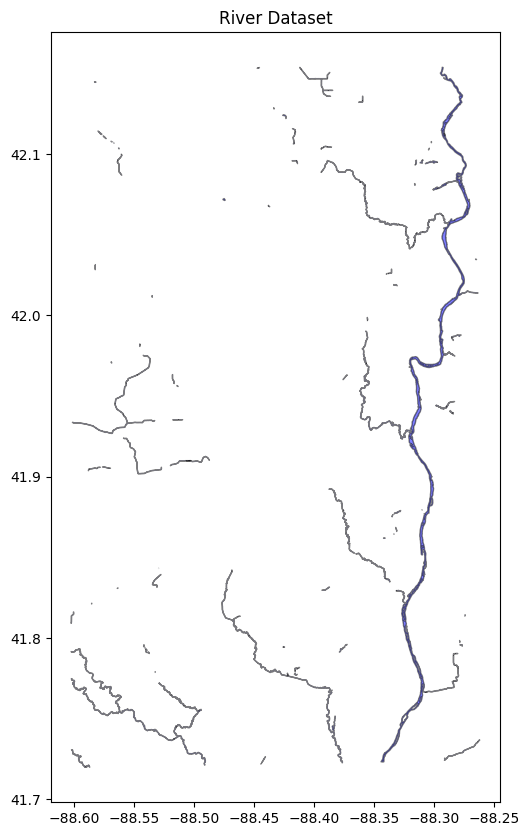

In [ ]:
import matplotlib.pyplot as plt 

ax = river_dataset.gdf.plot(figsize=(10, 10), color='blue', alpha=0.5, edgecolor='k')
plt.title('River Dataset')
plt.show()

In [ ]:
type(river_dataset.gdf.iloc[0])

pandas.core.series.Series

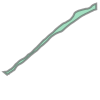

In [ ]:
river_dataset.gdf.iloc[0]["geometry"]

In [ ]:
print(river_dataset.gdf["geometry"][4])

POLYGON ((-88.26169227414917 41.73686943145013, -88.26169089435987 41.7367733070211, -88.26170813320333 41.73676823892638, -88.26173406722755 41.73676143830215, -88.26173993366746 41.736757700960204, -88.26175669186968 41.73674805697424, -88.26178641332552 41.73673532276948, -88.26182620079082 41.73671511325158, -88.26184253647892 41.73670672023427, -88.26187435487417 41.736692741161214, -88.26190242424602 41.73667687471074, -88.26192503436955 41.736666308905185, -88.26196023585939 41.73664452155732, -88.26198581189517 41.736626457970175, -88.26201349524382 41.736604959698624, -88.26204158132175 41.73658596479538, -88.2620654836773 41.73656789654358, -88.26209441012718 41.73654796631546, -88.26211871791307 41.73653302758177, -88.26214387679185 41.73651464765261, -88.26216611141207 41.736496573676796, -88.26219338103587 41.73647444895239, -88.26222022840885 41.7364523218376, -88.26224961854852 41.73642425993678, -88.26226850151296 41.73640805256197, -88.26228862926165 41.73639372589771,

In [ ]:
river_dataset.gdf.head(2)

OBJECTID_1  OBJECTID         FCODE AddUser AddDate EditUser EditDate  \
4           7         7  STREAM/RIVER    None    None     None     None   
6           9         9  STREAM/RIVER    None    None     None     None   

      Shape_STAr    Shape_STLe  \
4   11726.041740   1275.191296   
6  212818.638366  19090.189595   

                                            geometry  
4  POLYGON ((-88.26169 41.73687, -88.26169 41.736...  
6  POLYGON ((-88.28127 41.72802, -88.28127 41.728...

# What does each row of the gdf look like?

In [ ]:
import geopandas as gpd
from shapely.geometry import box
import matplotlib.pyplot as plt

# Select the first row (or any row of your choice) from river_dataset.gdf
def plot_row(row_geometry):
    minx, miny, maxx, maxy = row_geometry.bounds

    # Create a Polygon from the bounding box
    bbox = box(minx, miny, maxx, maxy)

    # Create a GeoDataFrame for the bounding box (to plot)
    bbox_gdf = gpd.GeoDataFrame(geometry=[bbox])

    # Plot the original geometry and its bounding box
    fig, ax = plt.subplots()

    # Plot both the geometry and bounding box
    river_dataset.gdf.plot(ax=ax, color='blue', marker='o', label='Original Geometry')
    bbox_gdf.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=2, label='Bounding Box')

    # Set equal aspect ratio
    ax.set_aspect('equal')

    # Zoom to the bounding box extent by setting axis limits
    ax.set_xlim([minx - 0.01, maxx + 0.01])
    ax.set_ylim([miny - 0.01, maxy + 0.01])

    plt.show()


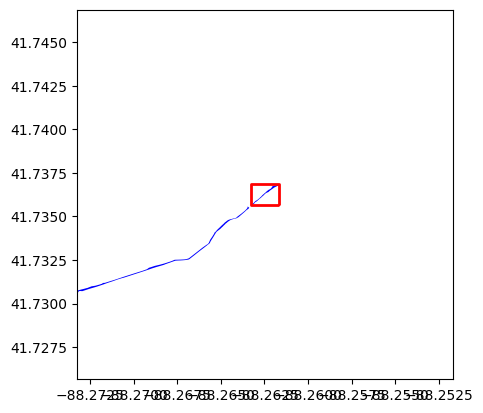

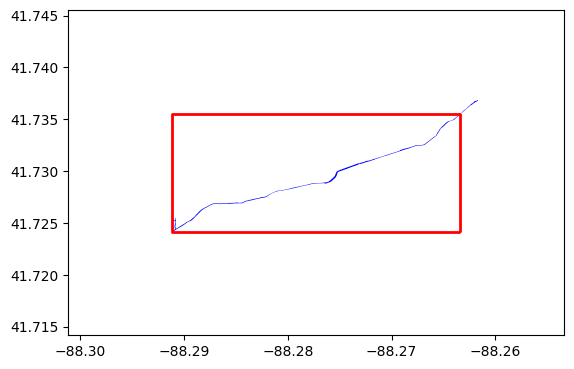

In [ ]:
plot_row(river_dataset.gdf.geometry.iloc[0])
plot_row(river_dataset.gdf.geometry.iloc[1])



In [ ]:
row_geometry = river_dataset.gdf.geometry.iloc[0]

# List all methods and attributes available for the geometry
methods = dir(row_geometry)
print(methods)


['__and__', '__bool__', '__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__geo_interface__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__nonzero__', '__or__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__slots__', '__str__', '__sub__', '__subclasshook__', '__xor__', '_geom', '_geom_prepared', '_ndim', '_repr_svg_', 'almost_equals', 'area', 'boundary', 'bounds', 'buffer', 'centroid', 'contains', 'contains_properly', 'convex_hull', 'coords', 'covered_by', 'covers', 'crosses', 'difference', 'disjoint', 'distance', 'dwithin', 'envelope', 'equals', 'equals_exact', 'exterior', 'from_bounds', 'geom_type', 'geometryType', 'has_z', 'hausdorff_distance', 'interiors', 'interpolate', 'intersection', 'intersects', 'is_closed', 'is_empty', 'is_ring', 'is_simple', 'is_valid', 'length', 'line_interpolate_point', 'line_locate_point', 

In [ ]:
print("Dataset Bounds:", river_dataset.bounds)

Dataset Bounds: BoundingBox(minx=-89.60247504118747, maxx=-87.23767873853359, miny=40.71979852550066, maxy=43.17920539923875, mint=0.0, maxt=9.223372036854776e+18)


In [ ]:
# Calculate lengths and areas
river_lengths = river_dataset.gdf.geometry.length  # Lengths in the units of the CRS
river_areas = river_dataset.gdf.geometry.area      # Areas in the units of the CRS

# Add lengths and areas to the GeoDataFrame
river_dataset.gdf['length'] = river_lengths
river_dataset.gdf['area'] = river_areas

# Summary statistics
print(river_dataset.gdf[['length', 'area']].describe())


           length          area
count  176.000000  1.760000e+02
mean     0.031831  5.563998e-06
std      0.171358  6.218788e-05
min      0.000006  2.876795e-13
25%      0.001196  3.587285e-08
50%      0.004258  1.494944e-07
75%      0.013419  5.981931e-07
max      2.092983  8.245790e-04


/tmp/ipykernel_1270912/519197894.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  river_lengths = river_dataset.gdf.geometry.length  # Lengths in the units of the CRS
/tmp/ipykernel_1270912/519197894.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  river_areas = river_dataset.gdf.geometry.area      # Areas in the units of the CRS


In [1]:
import torch
from torchgeo.datasets import BoundingBox
from kc import KaneCounty
import sys
import os

# Load the configuration settings
DATA_ROOT = "/net/projects/cmap/data"
KC_SHAPE_ROOT = os.path.join(DATA_ROOT, "kane-county-data")
KC_SHAPE_FILENAME = "KC_StormwaterDataJan2024.gdb.zip"  # Filename from config
KC_LAYER = 4  # Layer number from config
KC_LABELS = {
    "BACKGROUND": 0,
    "POND": 1,
    "WETLAND": 2,
    "DRY BOTTOM - TURF": 3,
    "DRY BOTTOM - MESIC PRAIRIE": 4,
}

# Assume the full path to the GeoPackage
path = os.path.join(KC_SHAPE_ROOT, KC_SHAPE_FILENAME)

# Configuration for the dataset
labels = KC_LABELS
patch_size = 256  # Size of the patches to be extracted
dest_crs = "EPSG:4326"  # Desired Coordinate Reference System (WGS84)
resolution = 0.0001  # Spatial resolution of the dataset

# Update configs to include the layer name
configs = (KC_LAYER, labels, patch_size, dest_crs, resolution)

# Create an instance of the KaneCounty dataset
kc_dataset = KaneCounty(path, configs)

# Example bounding box query (minx, maxx, miny, maxy, mint, maxt)
# Adjusted to fit within the dataset bounds
bbox = BoundingBox(
    minx=-89.6,       # Adjusted within the dataset minx
    maxx=-87.2,       # Adjusted within the dataset maxx
    miny=40.72,       # Adjusted within the dataset miny
    maxy=43.18,       # Adjusted within the dataset maxy
    mint=0,           # Optional: you can leave this as is
    maxt=sys.maxsize  # Optional: you can leave this as is
)

# Fetch data for this bounding box
try:
    sample = kc_dataset[bbox]  # Fetch sample for the bounding box
    # Print the sample (mask, CRS, bounding box)
    print("Mask shape:", sample['mask'].shape)
    print("CRS:", sample['crs'])
    print("Bounding Box:", sample['bbox'])
except IndexError as e:
    print(f"Error: {e}")


Initial Kane County GeoDataFrame loaded:
           BasinType                                           geometry
0               POND  MULTIPOLYGON (((945992.273 1935539.526, 945981...
1  DRY BOTTOM - TURF  MULTIPOLYGON (((957439.997 1930555.492, 957416...
2               POND  MULTIPOLYGON (((947040.816 1927034.962, 947028...
3               POND  MULTIPOLYGON (((948408.045 1926341.826, 948397...
4               POND  MULTIPOLYGON (((947424.509 1925889.426, 947443...
Kane countys filtered gdf
           BasinType                                           geometry
0               POND  MULTIPOLYGON (((-88.47404 41.98057, -88.47408 ...
1  DRY BOTTOM - TURF  MULTIPOLYGON (((-88.43192 41.96693, -88.43200 ...
2               POND  MULTIPOLYGON (((-88.47013 41.95723, -88.47018 ...
3               POND  MULTIPOLYGON (((-88.46510 41.95534, -88.46514 ...
4               POND  MULTIPOLYGON (((-88.46872 41.95409, -88.46865 ...
Mask shape: torch.Size([24600, 24000])
CRS: EPSG:4326
Bounding Box: B

In [2]:
from rtree import index

counter = 0


# Assuming 'rtree_index' is your Rtree index instance
for item in kc_dataset.index.intersection(kc_dataset.index.bounds, objects=True):
    print(f"ID: {item.id}, Bounds: {item.bbox}, row: {item.object}")
    counter += 1

print("count:", counter)


ID: 120, Bounds: [-89.308384794564, 40.78558393530391, 0.0, -87.30811891685462, 42.78733016865153, 9.223372036854776e+18], row: BasinType                                                 POND
geometry     MULTIPOLYGON (((-88.3082311851474 41.785584297...
Name: 124, dtype: object
ID: 4066, Bounds: [-89.30937411529885, 40.82103650092118, 0.0, -87.30802421939985, 42.8215161191644, 9.223372036854776e+18], row: BasinType                                    DRY BOTTOM - TURF
geometry     MULTIPOLYGON (((-88.30935873071356 41.82119534...
Name: 4195, dtype: object
ID: 3301, Bounds: [-89.31058886353078, 40.797540917359115, 0.0, -87.30800246279237, 42.7978295010559, 9.223372036854776e+18], row: BasinType                                              WETLAND
geometry     MULTIPOLYGON (((-88.31022845507192 41.79779523...
Name: 3401, dtype: object
ID: 3923, Bounds: [-89.30862274543527, 40.78967718540893, 0.0, -87.30793406126729, 42.790383400579266, 9.223372036854776e+18], row: BasinType               

In [ ]:
import pandas as pd
import geopandas as gpd

combo = kc_dataset | river_dataset

combo = gpd.GeoDataFrame(pd.concat([kc_dataset.gdf, river_dataset.gdf], ignore_index=True))


In [5]:
combo

BasinType                                           geometry  \
0                  POND  MULTIPOLYGON (((-88.47404 41.98057, -88.47408 ...   
1     DRY BOTTOM - TURF  MULTIPOLYGON (((-88.43192 41.96693, -88.43200 ...   
2                  POND  MULTIPOLYGON (((-88.47013 41.95723, -88.47018 ...   
3                  POND  MULTIPOLYGON (((-88.46510 41.95534, -88.46514 ...   
4                  POND  MULTIPOLYGON (((-88.46872 41.95409, -88.46865 ...   
...                 ...                                                ...   
5360                NaN  POLYGON ((-88.37319 41.86500, -88.37318 41.864...   
5361                NaN  POLYGON ((-88.36353 41.85235, -88.36353 41.852...   
5362                NaN  POLYGON ((-88.28167 41.78311, -88.28167 41.783...   
5363                NaN  POLYGON ((-88.41455 41.77710, -88.41454 41.777...   
5364                NaN  POLYGON ((-88.47093 41.83721, -88.47095 41.837...   

      OBJECTID_1  OBJECTID         FCODE AddUser AddDate      EditUser  \
0            NaN       NaN           NaN     NaN     NaN           NaN   
1            NaN       NaN           NaN     NaN     NaN           NaN   
2            NaN       NaN           NaN     NaN     NaN           NaN   
3            NaN       NaN           NaN     NaN     NaN           NaN   
4            NaN       NaN           NaN     NaN     NaN           NaN   
...          ...       ...           ...     ...     ...           ...   
5360      4216.0     923.0  STREAM/RIVER    None    None          None   
5361      4234.0     808.0  STREAM/RIVER    None    None          None   
5362      4245.0     160.0  STREAM/RIVER    None    None          None   
5363      4254.0     365.0  STREAM/RIVER    None    None          None   
5364      4266.0     302.0  STREAM/RIVER    None    None  EDITORGISJCV   

        EditDate    Shape_STAr     Shape_STLe  
0            NaN           NaN            NaN  
1            NaN           NaN            NaN  
2            NaN           NaN            NaN  
3            NaN           NaN            NaN  
4            NaN           NaN            NaN  
...          ...           ...            ...  
5360        None  1.738441e+05   15887.315082  
5361        None  3.029537e+05   25986.099491  
5362        None  1.664170e+04    2086.636830  
5363        None  2.516888e+04    1991.359150  
5364  2020-01-13  2.858100e+06  174589.657904  

[5365 rows x 11 columns]

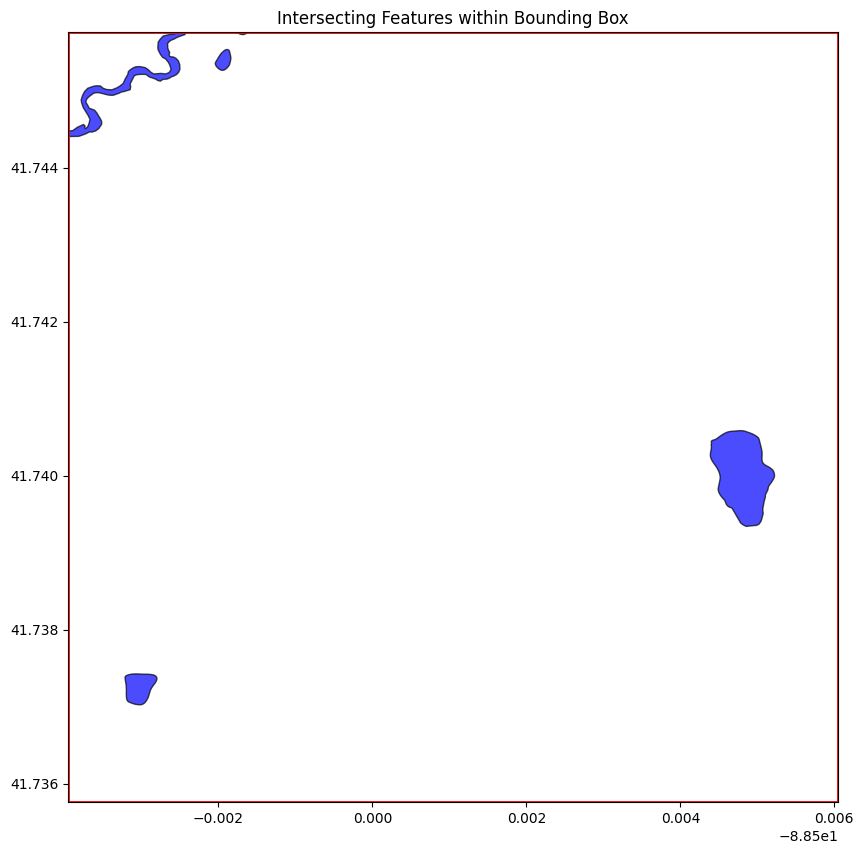

In [9]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box
import random

# Define the extent of your combo GeoDataFrame
minx, miny, maxx, maxy = combo.total_bounds

# Generate random coordinates within the extent
width, height = 0.01, 0.01  # Set desired bounding box size
random_x = random.uniform(minx, maxx - width)
random_y = random.uniform(miny, maxy - height)

# Create a random bounding box geometry
random_bbox = box(random_x, random_y, random_x + width, random_y + height)

# Select features in combo that intersect with the random bounding box
intersecting_features = combo[combo.geometry.intersects(random_bbox)]

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))

# Only plot intersecting features and set axis limits to focus on the bounding box
if not intersecting_features.empty:
    intersecting_features.plot(ax=ax, color="blue", edgecolor="black", alpha=0.7)

# Plot the bounding box in red
gpd.GeoSeries([random_bbox]).plot(ax=ax, color="none", edgecolor="red", linewidth=2)

# Zoom in to the bounding box area
ax.set_xlim(random_bbox.bounds[0], random_bbox.bounds[2])
ax.set_ylim(random_bbox.bounds[1], random_bbox.bounds[3])

# Set an equal aspect ratio for accurate spatial representation
ax.set_aspect('equal')
plt.title("Intersecting Features within Bounding Box")
plt.show()


# Inspect KC Data

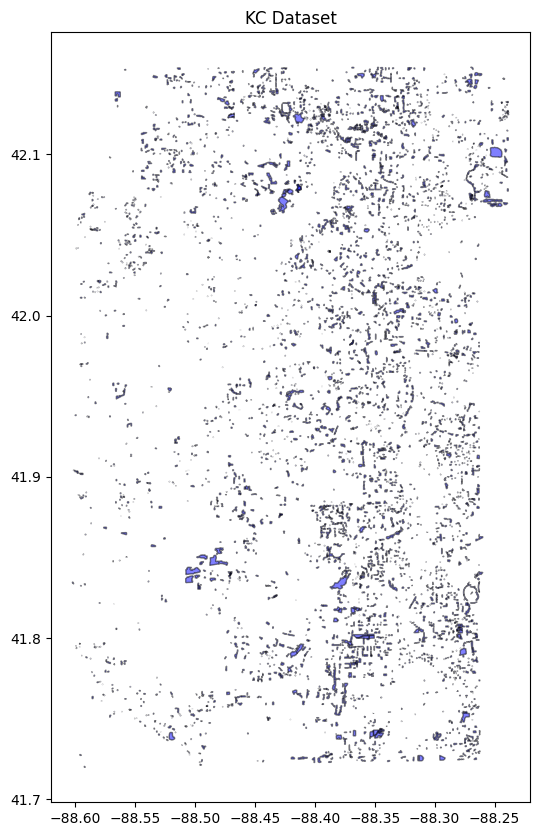

In [13]:
ax = kc_dataset.gdf.plot(figsize=(10, 10), color='blue', alpha=0.5, edgecolor='k')
plt.title('KC Dataset')
plt.show()

/tmp/ipykernel_1270912/3597410549.py:14: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


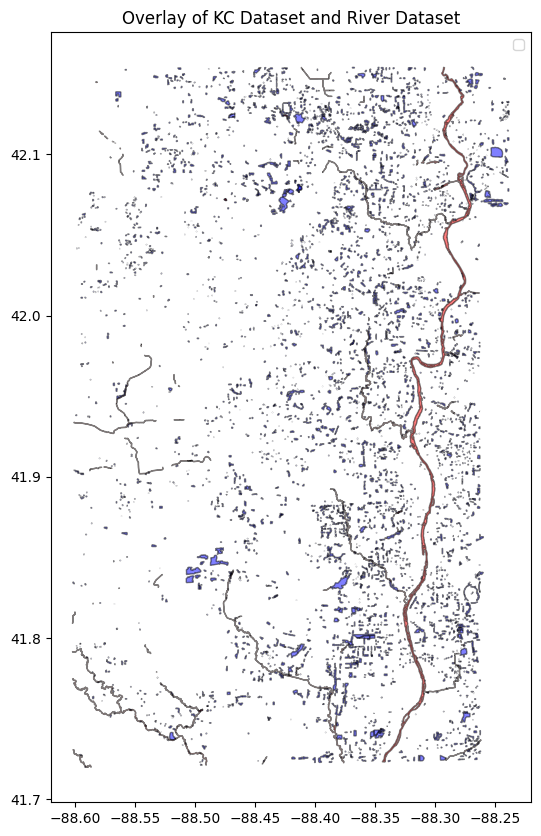

In [14]:
import matplotlib.pyplot as plt

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the KC dataset
kc_dataset.gdf.plot(ax=ax, color='blue', alpha=0.5, edgecolor='k', label='KC Dataset')

# Plot the river dataset on the same axis
river_dataset.gdf.plot(ax=ax, color='red', alpha=0.5, edgecolor='k', label='River Dataset')

# Add title and legend
plt.title('Overlay of KC Dataset and River Dataset')
plt.legend()
plt.show()


In [15]:
# don't plot gdf; plot combined dataset
# need to confirm that we can get bbox from combined dataset so we can get river/kc both

In [16]:
kc_dataset.gdf.head(3)

BasinType                                           geometry
0               POND  MULTIPOLYGON (((-88.47404 41.98057, -88.47408 ...
1  DRY BOTTOM - TURF  MULTIPOLYGON (((-88.43192 41.96693, -88.43200 ...
2               POND  MULTIPOLYGON (((-88.47013 41.95723, -88.47018 ...

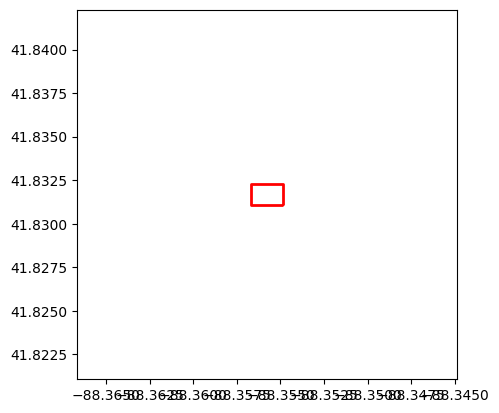

In [17]:
plot_row(kc_dataset.gdf.geometry.iloc[500])

# Find overlap between KC and River Data Objects

In [19]:
kc_dataset.gdf.head(2)

BasinType                                           geometry
0               POND  MULTIPOLYGON (((-88.47404 41.98057, -88.47408 ...
1  DRY BOTTOM - TURF  MULTIPOLYGON (((-88.43192 41.96693, -88.43200 ...

In [20]:
import geopandas as gpd
from shapely.geometry import box
import pandas as pd

# Step 1: Access the GeoDataFrames from your custom RiverDataset class
river_gdf = river_dataset.gdf
kc_gdf = kc_dataset.gdf

# Step 2: Combine datasets into one GeoDataFrame
combined_gdf = pd.concat([river_gdf, kc_gdf], ignore_index=True)

# Step 3: Generate chips over the bounding box of your dataset
chip_size = 0.005  # Adjust this size based on your needs
minx, miny, maxx, maxy = combined_gdf.total_bounds

chips = []

# Create chips over the bounding box
x = minx
while x < maxx:
    y = miny
    while y < maxy:
        chip = box(x, y, x + chip_size, y + chip_size)
        chips.append(chip)
        y += chip_size
    x += chip_size

# Convert chips to a GeoDataFrame
chips_gdf = gpd.GeoDataFrame(geometry=chips, crs=combined_gdf.crs)

# Step 4: Perform spatial joins to find chips that contain actual geometries
# Find chips that overlap with rivers
river_chips = gpd.sjoin(chips_gdf, river_gdf, how="inner", predicate="intersects")

# Find chips that overlap with kc objects
kc_chips = gpd.sjoin(chips_gdf, kc_gdf, how="inner", predicate="intersects")

# Step 5: Combine the results
# Combine the chips containing rivers and kc objects into one GeoDataFrame
combined_chips = pd.concat([river_chips, kc_chips], ignore_index=True).drop_duplicates()

# Step 6: Merge overlapping chips into a single layer
merged_chips = combined_chips.dissolve()

# Now merged_chips contains a single layer of chips
print(merged_chips)


                                            geometry  index_right  OBJECTID_1  \
0  MULTIPOLYGON (((-88.58748 41.72480, -88.58248 ...          306       448.0   

   OBJECTID         FCODE AddUser AddDate      EditUser    EditDate  \
0     502.0  STREAM/RIVER    None    None  EDITORGISJCV  2018-11-08   

      Shape_STAr    Shape_STLe    length      area BasinType  
0  200773.926749  15320.271333  0.048821  0.000002   WETLAND  


In [8]:

import geopandas as gpd
from shapely.geometry import box
import pandas as pd

# Step 1: Access the GeoDataFrames from your custom RiverDataset class
river_gdf = river_dataset.gdf

# Step 3: Generate chips over the bounding box of your dataset
chip_size = 0.005  # Adjust this size based on your needs
minx, miny, maxx, maxy = river_gdf.total_bounds

chips = []
lst = []

for _, row in river_gdf.iterrows():
    # Get the bounds of each geometry
    minx, miny, maxx, maxy = row['geometry'].bounds
    x = minx
    i = 0  # Initialize chip index counter

    # Iterate over the x-axis within the geometry bounds
    while x < maxx:
        y = miny

        # Iterate over the y-axis within the geometry bounds
        while y < maxy:
            # Define the chip coordinates and additional bounds if needed
            coords = (x, y, x + chip_size, y + chip_size)
            chip = box(x,y,x+chip_size,y+chip_size)
            
            # Insert chip into the spatial index
            #self.index.insert(i, coords, row)
            lst.append([i,coords,row])
            i += 1  # Increment the index for each chip
            #print(i)  # Optional: print chip index to track progress
            
            y += chip_size  # Move to the next chip in the y-direction
            chips.append(chip)

        x += chip_size  # Move to the next chip in the x-direction

# Convert chips to a GeoDataFrame
chips_gdf = gpd.GeoDataFrame(geometry=chips, crs=river_gdf.crs)

# Step 4: Perform spatial joins to find chips that contain actual geometries
# Find chips that overlap with rivers
river_chips = gpd.sjoin(chips_gdf, river_gdf, how="inner", predicate="intersects")

# Step 6: Merge overlapping chips into a single layer
merged_chips = river_chips.dissolve()

# Now merged_chips contains a single layer of chips
print(merged_chips)


OBJECTID_1                                                    7
OBJECTID                                                      7
FCODE                                              STREAM/RIVER
AddUser                                                    None
AddDate                                                    None
EditUser                                                   None
EditDate                                                   None
Shape_STAr                                          11726.04174
Shape_STLe                                          1275.191296
geometry      POLYGON ((-88.26169227414917 41.73686943145013...
Name: 4, dtype: object
OBJECTID_1                                                    9
OBJECTID                                                      9
FCODE                                              STREAM/RIVER
AddUser                                                    None
AddDate                                                    None
EditUser         

In [6]:
import geopandas as gpd
from shapely.geometry import box
import pandas as pd

# Step 1: Access the GeoDataFrames from your custom RiverDataset class
river_gdf = river_dataset.gdf

# Step 3: Generate chips over the bounding box of your dataset
chip_size = 0.005  # Adjust this size based on your needs
minx, miny, maxx, maxy = river_gdf.total_bounds

chips = []

# Create chips over the bounding box
x = minx
while x < maxx:
    y = miny
    while y < maxy:
        chip = box(x, y, x + chip_size, y + chip_size)
        chips.append(chip)
        y += chip_size
    x += chip_size

# Convert chips to a GeoDataFrame
chips_gdf = gpd.GeoDataFrame(geometry=chips, crs=river_gdf.crs)

# Step 4: Perform spatial joins to find chips that contain actual geometries
# Find chips that overlap with rivers
river_chips = gpd.sjoin(chips_gdf, river_gdf, how="inner", predicate="intersects")

# Step 6: Merge overlapping chips into a single layer
merged_chips = river_chips.dissolve()

# Now merged_chips contains a single layer of chips
print(merged_chips)


                                            geometry  index_right  OBJECTID_1  \
0  MULTIPOLYGON (((-88.59748 41.72980, -88.59248 ...          306         448   

   OBJECTID         FCODE AddUser AddDate      EditUser    EditDate  \
0       502  STREAM/RIVER    None    None  EDITORGISJCV  2018-11-08   

      Shape_STAr    Shape_STLe  
0  200773.926749  15320.271333  


In [48]:
merged_chips.head(3)

geometry  index_right  OBJECTID_1  \
0  MULTIPOLYGON (((-88.59748 41.72980, -88.59248 ...          306         448   

   OBJECTID         FCODE AddUser AddDate      EditUser    EditDate  \
0       502  STREAM/RIVER    None    None  EDITORGISJCV  2018-11-08   

      Shape_STAr    Shape_STLe  
0  200773.926749  15320.271333

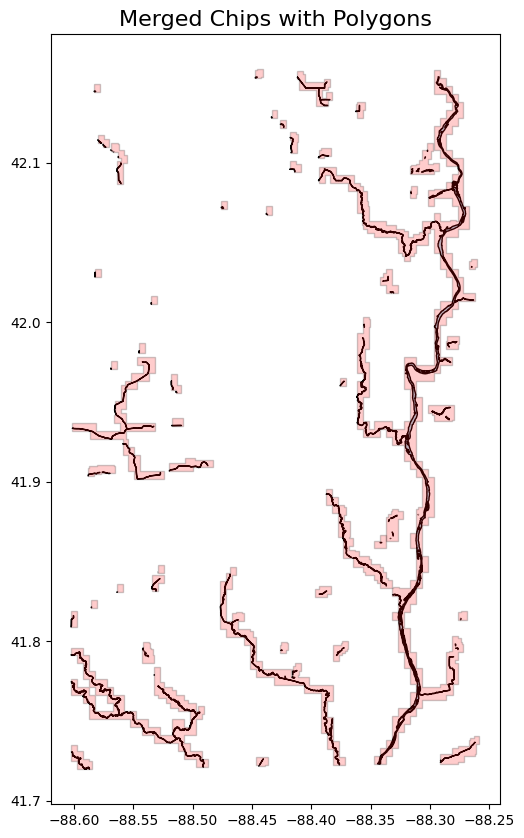

In [6]:
import matplotlib.pyplot as plt

# Create a larger figure
fig, ax = plt.subplots(figsize=(12, 10))  # Adjust width and height as needed

# Plot the combined GeoDataFrame
base = river_gdf.plot(ax=ax, color='lightblue', edgecolor='black', alpha=1)

# Plot the merged chips with outlines
merged_chips.plot(ax=base, color='red', edgecolor='black', alpha=0.2, linewidth=1)  # Adjust linewidth as needed

# Set the title
plt.title("Merged Chips with Polygons", fontsize=16)  # Updated title for clarity

# Show the plot
plt.show()


In [7]:
lst

[[0,
  (-88.26327873853359,
   41.735651814836295,
   -88.25827873853359,
   41.7406518148363),
  OBJECTID_1                                                    7
  OBJECTID                                                      7
  FCODE                                              STREAM/RIVER
  AddUser                                                    None
  AddDate                                                    None
  EditUser                                                   None
  EditDate                                                   None
  Shape_STAr                                          11726.04174
  Shape_STLe                                          1275.191296
  geometry      POLYGON ((-88.26169227414917 41.73686943145013...
  Name: 4, dtype: object],
 [0,
  (-88.29119267475515,
   41.724183432165994,
   -88.28619267475516,
   41.729183432165996),
  OBJECTID_1                                                    9
  OBJECTID                                           

## Chips with river and KC objects

In [23]:
import geopandas as gpd
from shapely.geometry import box
import pandas as pd

# Step 1: Access the GeoDataFrames from your custom classes
river_gdf = river_dataset.gdf
kc_gdf = kc_dataset.gdf

# Step 2: Generate chips over the bounding box of your datasets
chip_size = 0.005  # Define the size of each chip
minx, miny, maxx, maxy = river_gdf.total_bounds  # You can also use kc_gdf.total_bounds if needed

chips = []

# Create chips over the bounding box
x = minx
while x < maxx:
    y = miny
    while y < maxy:
        chip = box(x, y, x + chip_size, y + chip_size)
        chips.append(chip)
        y += chip_size
    x += chip_size

# Convert chips to a GeoDataFrame
chips_gdf = gpd.GeoDataFrame(geometry=chips, crs=river_gdf.crs)

# Step 3: Perform spatial join to find chips that contain rivers
rivers_in_chips = gpd.sjoin(chips_gdf, river_gdf, how="inner", op="contains")

# Step 4: Perform spatial join to find chips that contain kc objects
kc_in_chips = gpd.sjoin(chips_gdf, kc_gdf, how="inner", op="contains")

# Step 5: Find chips that contain both rivers and kc objects
# This will give you the chips that are common in both results
both_objects_chips = pd.merge(rivers_in_chips, kc_in_chips, on="geometry")

# Now you have the chips that contain both a river and a kc object

/home/annapoon/micromamba/envs/cmap/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/home/annapoon/micromamba/envs/cmap/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


/tmp/ipykernel_1270912/901161958.py:30: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


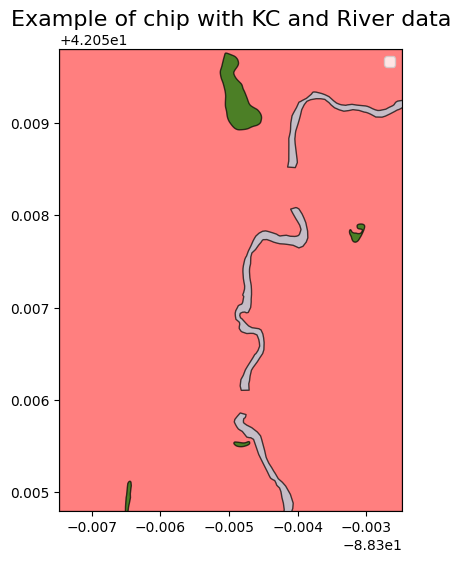

In [25]:
# Check if there are any chips that contain both objects
if not both_objects_chips.empty:
    # Select one chip (for example, the first one)
    chip_to_visualize = both_objects_chips.iloc[50]

    # Create a GeoDataFrame for the selected chip
    chip_gdf = gpd.GeoDataFrame(geometry=[chip_to_visualize['geometry']], crs=both_objects_chips.crs)

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(6, 6))

    # Plot the selected chip (as a GeoDataFrame)
    chip_gdf.plot(ax=ax, color='red', edgecolor='black', alpha=0.5, label='Selected Chip')

    # Plot the actual river geometries that intersect with the chip
    rivers_in_chip = river_gdf[river_gdf.intersects(chip_gdf.geometry.values[0])]
    rivers_in_chip.plot(ax=ax, color='lightblue', edgecolor='black', alpha=0.7, label='Rivers')

    # Plot the actual kc geometries that intersect with the chip
    kc_in_chip = kc_gdf[kc_gdf.intersects(chip_gdf.geometry.values[0])]
    kc_in_chip.plot(ax=ax, color='green', edgecolor='black', alpha=0.7, label='KC Objects')

    # Set the limits of the plot to the bounds of the chip
    minx, miny, maxx, maxy = chip_gdf.total_bounds
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)

    # Add a title and legend
    ax.set_title("Example of chip with KC and River data", fontsize=16)
    ax.legend()

    # Show the plot
    plt.show()
else:
    print("No chips contain both river and KC objects.")

# IMPLEMENT CHIP LOGIC IN RD.PY


In [3]:
import torch
from torchgeo.datasets import BoundingBox
from rd_copy_copy import RiverDataset
import sys

# Assume 'path_to_data.gpkg' is the path to your geospatial data file
path = "/net/projects/cmap/data/kane-county-data/Kane_Co_Open_Water_Layer.zip"

# Configuration for the dataset
labels = {
    "STREAM/RIVER": 1  # Label for rivers and streams in the dataset
}
patch_size = 256  # Size of the patches to be extracted
# check the patch vs chip size
dest_crs = "EPSG:4326"  # Desired Coordinate Reference System (WGS84)
resolution = 0.0005  # Spatial resolution of the dataset

configs = (labels, patch_size, dest_crs, resolution)


# Create an instance of the RiverDataset
river_dataset = RiverDataset(path, configs)

Initial GeoDataFrame loaded:
   OBJECTID_1  OBJECTID         FCODE AddUser AddDate      EditUser  \
0           3         3     LAKE/POND    None    None  EDITORGISJCV   
1           4         4     LAKE/POND    None    None  EDITORGISJCV   
2           5         5     LAKE/POND    None    None  EDITORGISJCV   
3           6         6     LAKE/POND    None    None  EDITORGISJCV   
4           7         7  STREAM/RIVER    None    None          None   

     EditDate    Shape_STAr   Shape_STLe  \
0  2021-09-23  19202.263858   553.773198   
1  2017-11-02  93650.125726  1150.204623   
2  2017-11-02  28447.559086  1017.527238   
3  2017-11-02  22350.795461   779.240851   
4        None  11726.041740  1275.191296   

                                            geometry  
0  POLYGON ((1000903.661 1847211.970, 1000899.841...  
1  POLYGON ((1000295.575 1846736.918, 1000286.206...  
2  POLYGON ((1000884.503 1846937.163, 1000893.378...  
3  POLYGON ((1001358.114 1846711.121, 1001361.239...  
4  P

In [10]:
from rtree import index

counter = 0


# Assuming 'rtree_index' is your Rtree index instance
for item in river_dataset.index.intersection(river_dataset.index.bounds, objects=True):
    print(f"ID: {item.id}, Bounds: {item.bbox}, row: {item.object}")
    counter += 1

print("count:", counter)


ID: 654, Bounds: [-88.29247504118776, -88.28747504118776, 0.0, 42.03479852550082, 42.03979852550082, 9.223372036854776e+18], row: OBJECTID_1                                                   33
OBJECTID                                                     33
FCODE                                              STREAM/RIVER
AddUser                                                    None
AddDate                                                    None
EditUser                                           EDITORGISJCV
EditDate                                             2023-06-26
Shape_STAr                                        81745659.5535
Shape_STLe                                        680059.514125
geometry      POLYGON ((-88.33519870483617 41.93226506396128...
Name: 23, dtype: object
ID: 515, Bounds: [-88.32247504118773, -88.31747504118773, 0.0, 42.03979852550082, 42.04479852550082, 9.223372036854776e+18], row: OBJECTID_1                                                 4128
OBJECTID    

In [3]:
print(dir(river_dataset))


['__abstractmethods__', '__add__', '__and__', '__annotations__', '__class__', '__class_getitem__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getlabels__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__or__', '__orig_bases__', '__parameters__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_crs', '_is_protocol', '_load_and_prepare_data', '_populate_index', '_res', 'all_bands', 'all_colors', 'all_labels', 'bounds', 'colors', 'context_size', 'crs', 'filename_glob', 'files', 'gdf', 'index', 'is_image', 'labels', 'labels_inverse', 'res', 'transforms']


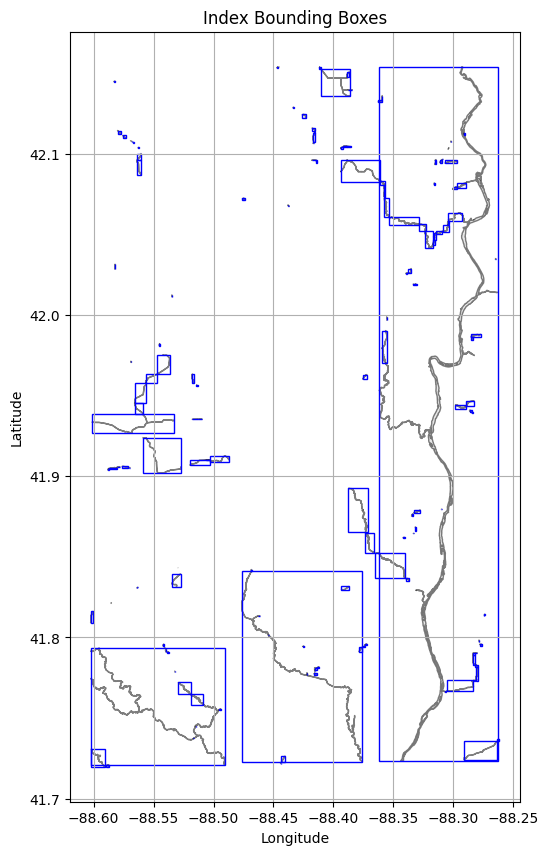

In [9]:
import matplotlib.pyplot as plt
import geopandas as gpd
import matplotlib.patches as patches

def plot_index(dataset, bbox_color="blue"):
    """
    Plots the bounding boxes stored in the dataset's index.
    
    Args:
        dataset: An instance of RiverDataset containing the index to plot.
        bbox_color: Color for the bounding boxes (default is 'blue').
    """
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot the main geometry of the dataset
    dataset.gdf.plot(ax=ax, facecolor="lightgray", edgecolor="black", alpha=0.5)

    # Check if the GeoDataFrame is empty
    if dataset.gdf.empty:
        print("The GeoDataFrame is empty.")
        return

    # Iterate over all geometries in the GeoDataFrame to plot their bounding boxes
    for idx in range(len(dataset.gdf)):
        geometry = dataset.gdf.geometry.iloc[idx]  # Use iloc for safe indexing
        bounds = geometry.bounds  # Get the bounding box (minx, miny, maxx, maxy)

        # Create a rectangle for each bounding box
        rect = patches.Rectangle(
            (bounds[0], bounds[1]),  # (minx, miny)
            bounds[2] - bounds[0],    # Width
            bounds[3] - bounds[1],    # Height
            linewidth=1, edgecolor=bbox_color, facecolor="none"
        )
        ax.add_patch(rect)

    ax.set_title("Index Bounding Boxes")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    plt.grid(True)
    plt.show()

# Assuming `river_dataset` is an instance of RiverDataset
plot_index(river_dataset)


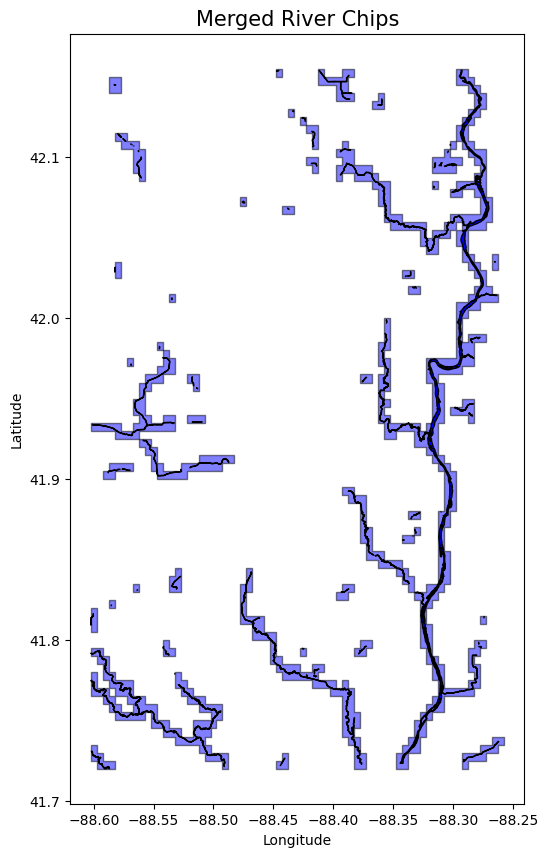

In [2]:
import matplotlib.pyplot as plt
import geopandas as gpd

# `self.merged_chips` is a GeoDataFrame
def plot_merged_chips(gdf, merged_chips):
    """Plots the merged river chips on a map."""
    # set up the plot
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # plot  merged chips
    merged_chips.plot(ax=ax, color='blue', edgecolor='black', alpha=0.5)
    
    # add a basemap
    gdf.plot(ax=ax, color='blue', edgecolor='black', alpha=1)
    
    ax.set_title("Merged River Chips", fontsize=15)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    
    plt.show()

plot_merged_chips(river_dataset.gdf, river_dataset.merged_chips)


In [6]:
print(type(river_dataset.index))


<class 'rtree.index.Index'>


# COMBINE KC AND RIVER DATASETS

In [1]:
import torch
from torchgeo.datasets import BoundingBox
from kc import KaneCounty
import sys
import os

# Load the configuration settings
DATA_ROOT = "/net/projects/cmap/data"
KC_SHAPE_ROOT = os.path.join(DATA_ROOT, "kane-county-data")
KC_SHAPE_FILENAME = "KC_StormwaterDataJan2024.gdb.zip"  # Filename from config
KC_LAYER = 4  # Layer number from config
KC_LABELS = {
    "BACKGROUND": 0,
    "POND": 1,
    "WETLAND": 2,
    "DRY BOTTOM - TURF": 3,
    "DRY BOTTOM - MESIC PRAIRIE": 4,
}
path = os.path.join(KC_SHAPE_ROOT, KC_SHAPE_FILENAME)
labels = KC_LABELS
patch_size = 256  # Size of the patches to be extracted
dest_crs = "EPSG:4326"  # Desired Coordinate Reference System (WGS84)
resolution = 0.0001  # Spatial resolution of the dataset
configs = (KC_LAYER, labels, patch_size, dest_crs, resolution)
kc_dataset = KaneCounty(path, configs)
bbox = BoundingBox(
    minx=-89.6,       # Adjusted within the dataset minx
    maxx=-87.2,       # Adjusted within the dataset maxx
    miny=40.72,       # Adjusted within the dataset miny
    maxy=43.18,       # Adjusted within the dataset maxy
    mint=0,           # Optional: you can leave this as is
    maxt=sys.maxsize  # Optional: you can leave this as is
)


# RIVER DATASET
from rd_copy_copy import RiverDataset

path = "/net/projects/cmap/data/kane-county-data/Kane_Co_Open_Water_Layer.zip"
labels = {
    "STREAM/RIVER": 1  # Label for rivers and streams in the dataset
}
patch_size = 256  # Size of the patches to be extracted
# check the patch vs chip size
dest_crs = "EPSG:4326"  # Desired Coordinate Reference System (WGS84)
resolution = 0.0001  # Spatial resolution of the dataset
configs = (labels, patch_size, dest_crs, resolution)
river_dataset = RiverDataset(path, configs)

Initial Kane County GeoDataFrame loaded:
           BasinType                                           geometry
0               POND  MULTIPOLYGON (((945992.273 1935539.526, 945981...
1  DRY BOTTOM - TURF  MULTIPOLYGON (((957439.997 1930555.492, 957416...
2               POND  MULTIPOLYGON (((947040.816 1927034.962, 947028...
3               POND  MULTIPOLYGON (((948408.045 1926341.826, 948397...
4               POND  MULTIPOLYGON (((947424.509 1925889.426, 947443...
Kane countys filtered gdf
           BasinType                                           geometry
0               POND  MULTIPOLYGON (((-88.47404 41.98057, -88.47408 ...
1  DRY BOTTOM - TURF  MULTIPOLYGON (((-88.43192 41.96693, -88.43200 ...
2               POND  MULTIPOLYGON (((-88.47013 41.95723, -88.47018 ...
3               POND  MULTIPOLYGON (((-88.46510 41.95534, -88.46514 ...
4               POND  MULTIPOLYGON (((-88.46872 41.95409, -88.46865 ...
Initial GeoDataFrame loaded:
   OBJECTID_1  OBJECTID         FCODE Ad

In [3]:
combo =   river_dataset | kc_dataset

In [4]:
from rtree import index

for item in kc_dataset.index.intersection(kc_dataset.index.bounds, objects=True):
    row = item.object
    print(f"ID: {item.id}, Bounds: {item.bbox}, row: {item.object}")
    break

# Assuming 'rtree_index' is your Rtree index instance
for item in river_dataset.index.intersection(river_dataset.index.bounds, objects=True):
    rrow = item.object
    print(f"ID: {item.id}, Bounds: {item.bbox}, row: {item.object}")
    break



ID: 120, Bounds: [-89.308384794564, 40.78558393530391, 0.0, -87.30811891685462, 42.78733016865153, 9.223372036854776e+18], row: BasinType                                                 POND
geometry     MULTIPOLYGON (((-88.3082311851474 41.785584297...
Name: 124, dtype: object
ID: 654, Bounds: [-88.29247504118776, -88.28747504118776, 0.0, 42.03479852550082, 42.03979852550082, 9.223372036854776e+18], row: FCODE                                            STREAM/RIVER
geometry    POLYGON ((-88.33519870483617 41.93226506396128...
Name: 23, dtype: object


In [6]:
import pandas as pd
pd.DataFrame(row)

124
BasinType                                               POND
geometry   MULTIPOLYGON (((-88.3082311851474 41.785584297...

In [7]:
import pandas as pd
pd.DataFrame(rrow[["FCODE", "geometry"]])

23
FCODE                                          STREAM/RIVER
geometry  POLYGON ((-88.33519870483617 41.93226506396128...

In [8]:
from rtree import index

kc_counter = 0

for item in kc_dataset.index.intersection(kc_dataset.index.bounds, objects=True):
    print(f"ID: {item.id}, Bounds: {item.bbox}, row: {item.object}")
    kc_counter += 1

print("kc chip count:", kc_counter)


ID: 120, Bounds: [-89.308384794564, 40.78558393530391, 0.0, -87.30811891685462, 42.78733016865153, 9.223372036854776e+18], row: BasinType                                                 POND
geometry     MULTIPOLYGON (((-88.3082311851474 41.785584297...
Name: 124, dtype: object
ID: 4066, Bounds: [-89.30937411529885, 40.82103650092118, 0.0, -87.30802421939985, 42.8215161191644, 9.223372036854776e+18], row: BasinType                                    DRY BOTTOM - TURF
geometry     MULTIPOLYGON (((-88.30935873071356 41.82119534...
Name: 4195, dtype: object
ID: 3301, Bounds: [-89.31058886353078, 40.797540917359115, 0.0, -87.30800246279237, 42.7978295010559, 9.223372036854776e+18], row: BasinType                                              WETLAND
geometry     MULTIPOLYGON (((-88.31022845507192 41.79779523...
Name: 3401, dtype: object
ID: 3923, Bounds: [-89.30862274543527, 40.78967718540893, 0.0, -87.30793406126729, 42.790383400579266, 9.223372036854776e+18], row: BasinType               

In [9]:
from rtree import index

river_counter = 0

# Assuming 'rtree_index' is your Rtree index instance
for item in river_dataset.index.intersection(river_dataset.index.bounds, objects=True):
    print(f"ID: {item.id}, Bounds: {item.bbox}, row: {item.object}")
    river_counter += 1

print("river chip count:", river_counter)


ID: 654, Bounds: [-88.29247504118776, -88.28747504118776, 0.0, 42.03479852550082, 42.03979852550082, 9.223372036854776e+18], row: FCODE                                            STREAM/RIVER
geometry    POLYGON ((-88.33519870483617 41.93226506396128...
Name: 23, dtype: object
ID: 515, Bounds: [-88.32247504118773, -88.31747504118773, 0.0, 42.03979852550082, 42.04479852550082, 9.223372036854776e+18], row: FCODE                                            STREAM/RIVER
geometry    POLYGON ((-88.32335198082977 42.05173488448165...
Name: 2792, dtype: object
ID: 537, Bounds: [-88.31747504118773, -88.31247504118774, 0.0, 42.03979852550082, 42.04479852550082, 9.223372036854776e+18], row: FCODE                                            STREAM/RIVER
geometry    POLYGON ((-88.31677657286757 42.04370000279212...
Name: 2790, dtype: object
ID: 538, Bounds: [-88.31747504118773, -88.31247504118774, 0.0, 42.03979852550082, 42.04479852550082, 9.223372036854776e+18], row: FCODE                           

In [10]:
from rtree import index

counter = 0

# Assuming 'rtree_index' is your Rtree index instance
for item in combo.index.intersection(combo.index.bounds, objects=True):
    print(f"ID: {item.id}, Bounds: {item.bbox}, row: {item.object}")
    counter += 1

print("count:", counter)


ID: 2190, Bounds: [-89.32937299388095, 40.84938376306609, 0.0, -87.32889144336717, 42.849626133303985, 9.223372036854776e+18], row: None
ID: 2175, Bounds: [-89.32907132769166, 40.84342454206758, 0.0, -87.32842376526774, 42.843834045348245, 9.223372036854776e+18], row: None
ID: 2188, Bounds: [-89.32940208020906, 40.87181293294685, 0.0, -87.32833824186861, 42.87260143542849, 9.223372036854776e+18], row: None
ID: 2121, Bounds: [-89.3291964898312, 40.859623487581864, 0.0, -87.3282979413673, 42.86027727508266, 9.223372036854776e+18], row: None
ID: 2180, Bounds: [-89.32857625413502, 40.83952197478164, 0.0, -87.32794741578178, 42.839917889782264, 9.223372036854776e+18], row: None
ID: 2183, Bounds: [-89.3283551213321, 40.8428089539495, 0.0, -87.32788108236953, 42.843139508407894, 9.223372036854776e+18], row: None
ID: 2122, Bounds: [-89.3283217994093, 40.86775397071321, 0.0, -87.32767593888174, 42.86878272067998, 9.223372036854776e+18], row: None
ID: 2177, Bounds: [-89.32790735968146, 40.838181

In [11]:
river_counter, kc_counter, counter

(764, 5189, 5953)

In [11]:
dir(river_dataset)[5:10]

['__class_getitem__', '__delattr__', '__dict__', '__dir__', '__doc__']

In [12]:
river_dataset.colors

{1: (255, 255, 0, 255)}

# NAIP

In [15]:
from torchgeo.datasets import NAIP, BoundingBox
import importlib.util
import matplotlib.pyplot as plt
import rasterio
import torch
from rasterio.plot import show
from torchgeo.datasets import NAIP, BoundingBox
#from config import config


def preprocess(sample):
    """Converts image data to float

    Args:
        sample: a piece of a raster image
    Returns:
        sample image data in float
    """
    if "image" in sample:
        sample["image"] = sample["image"].float() / 255.0
        return sample
    sample["mask"] = sample["mask"].float() / 255.0
    return sample




naip = NAIP(os.path.join(DATA_ROOT, "KC-images"), transforms=preprocess)


print(river_dataset.crs)
print(kc_dataset.crs)
print(naip.crs)

EPSG:4326
EPSG:4326
EPSG:26916


# Training Outputs

In [41]:
shapefile_path = "/net/projects/cmap/workspaces/annapoon/trial_test_run_3_trial0/test-images/epoch-4/POND"
contents = os.listdir(shapefile_path)

# Print the contents
for item in contents:
    print(item)

test_sample-4.0.8.png
test_sample-4.0.10.png
test_sample-4.0.9.png
test_sample-4.0.0.png
test_sample-4.0.12.png
test_sample-4.0.3.png
test_sample-4.0.4.png
test_sample-4.0.2.png


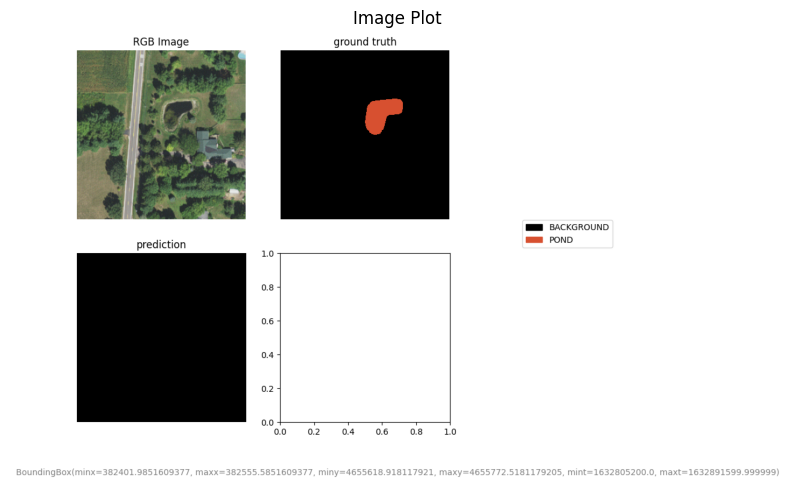

In [50]:
import geopandas as gpd
import matplotlib.image as mpimg

image_path = "/net/projects/cmap/workspaces/annapoon/trial_test_run_3_trial0/test-images/epoch-4/POND/test_sample-4.0.0.png"

img = mpimg.imread(image_path)

# Display
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')  # Turn off the axis
plt.title("Image Plot")
plt.show()

In [46]:
shapefile_path = "/net/projects/cmap/workspaces/annapoon/trial_test_run_3_trial0/test-images/epoch-4/WETLAND"
contents = os.listdir(shapefile_path)

# Print the contents
for item in contents:
    print(item)

test_sample-4.0.6.png
test_sample-4.0.11.png
test_sample-4.0.10.png


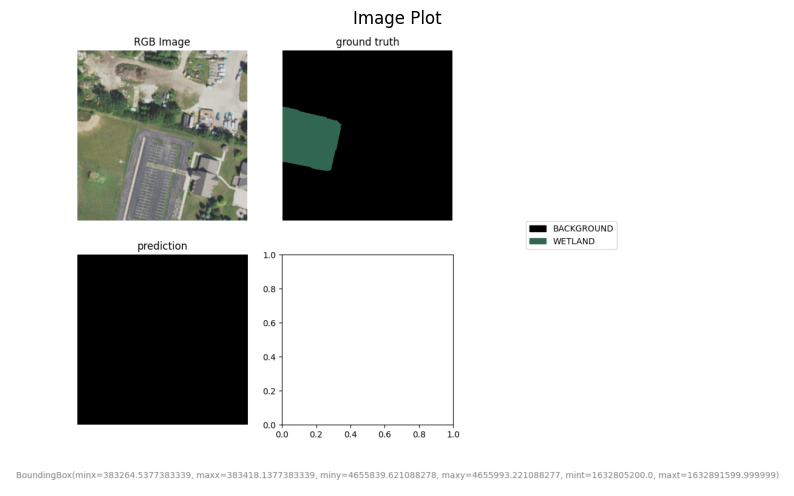

In [49]:
import geopandas as gpd
import matplotlib.image as mpimg

image_path = "/net/projects/cmap/workspaces/annapoon/trial_test_run_3_trial0/test-images/epoch-4/WETLAND/test_sample-4.0.11.png"

# Load the image
img = mpimg.imread(image_path)

# Display 
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')  # Turn off the axis
plt.title("Image Plot")
plt.show()